In [109]:
# -*- coding: utf-8 -*-
from __future__ import division
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
print (cv2.__version__)

3.4.3


In [43]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
!ls -al
os.getcwd()

Saving template.jpg to template.jpg
User uploaded file "template.jpg" with length 5126 bytes
total 276
drwxr-xr-x 1 root root   4096 Nov 10 06:34 .
drwxr-xr-x 1 root root   4096 Nov 10 05:54 ..
drwxr-xr-x 4 root root   4096 Nov  7 19:54 .config
-rw-r--r-- 1 root root  33099 Nov 10 06:21 gray_image.jpg
-rw-r--r-- 1 root root 218842 Nov 10 06:20 input_image.jpg
drwxr-xr-x 2 root root   4096 Nov  7 20:08 sample_data
-rw-r--r-- 1 root root   5126 Nov 10 06:34 template.jpg


'/content'

In [110]:
files_in_content = os.listdir('/content')
print ('The list of files in content folder are{files_in_content}'.format(files_in_content = files_in_content))

The list of files in content folder are['sample_data', '.config', 'input_image.jpg', 'template.jpg', 'drive', 'h.txt', 'adc.json', 'gray_image.jpg']


In [111]:
for files_present in files_in_content:
  if files_present.startswith("input_image"):
    image_file_full_path = "/content/" + files_present
    color_image_BGR = cv2.imread(image_file_full_path)
    image_height,image_width,image_channels = color_image_BGR.shape
    color_image_RGB = cv2.cvtColor(color_image_BGR,cv2.COLOR_BGR2RGB)
    print ('The image file present is {jpg_uploaded_file}'.format(jpg_uploaded_file = image_file_full_path))
    print ('The image dimension are, Height = {image_height},width = {image_width},Number of channels = {image_channels}'.format(image_height = image_height,image_width = image_width,image_channels = image_channels))

The image file present is /content/input_image.jpg
The image dimension are, Height = 668,width = 1000,Number of channels = 3


Text(0.5,0,'Input image')

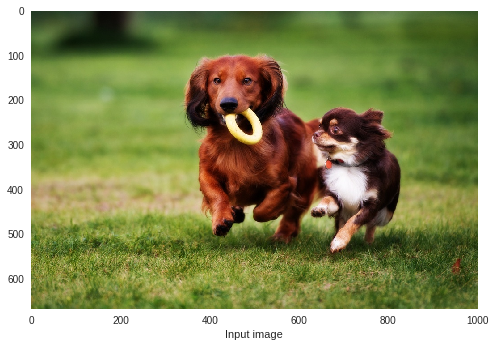

In [112]:
plt.figure()
plt.grid(False)
plt.imshow(color_image_RGB)
plt.xlabel("Input image")

In [0]:
def grabcut_manual_segemntation(image_original,approximate_rectangel):
	image = image_original.copy()
	mask = np.zeros(image.shape[:2],np.uint8)
	bgdModel = np.zeros((1,65),np.float64)
	fgdModel = np.zeros((1,65),np.float64)
	cv2.grabCut(image,mask,approximate_rectangel,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
	mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
	grabcut_segmented_image = image*mask2[:,:,np.newaxis]
	return grabcut_segmented_image

In [0]:
approximate_rectangel = (341,110,500,514)
grabcut_segmented_image = grabcut_manual_segemntation(color_image_RGB,approximate_rectangel)

Text(0.5,0,'grabcut_segmented_image')

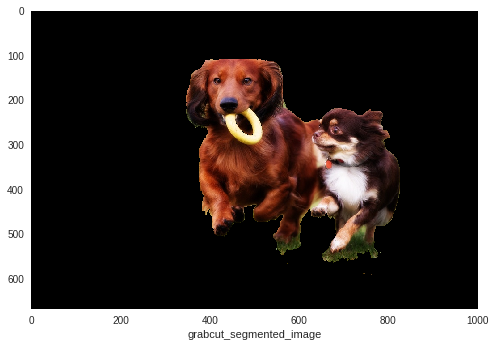

In [115]:
plt.figure()
plt.grid(False)
plt.imshow(grabcut_segmented_image)
plt.xlabel("grabcut_segmented_image")

In [0]:
def polygon_image_crop(pts,img):
	rect = cv2.boundingRect(pts)
	x,y,w,h = rect
	croped = img[y:y+h, x:x+w].copy()
	pts = pts - pts.min(axis=0)
	mask = np.zeros(croped.shape[:2], np.uint8)
	cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)
	dst = cv2.bitwise_and(croped, croped, mask=mask)
	bg = np.ones_like(croped, np.uint8)*255
	cv2.bitwise_not(bg,bg, mask=mask)
	dst2 = bg+ dst
	return dst2

def convex_hull(grabcut_segmented_image,original_image):
	area_list = []
	hull_list = []
	blur = cv2.blur(grabcut_segmented_image,(11,11))#very important

	gray_image = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)#get gray image data
	cv2.imwrite("gray_image.jpg",gray_image)
	thresholded_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY)[1]

	Cannyedges = cv2.Canny(thresholded_image,10,120)#detect the edges using canny

	im2, contours, hierarchy = cv2.findContours(Cannyedges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  
	contours = sorted(contours, key = cv2.contourArea, reverse = True)[:]# sort the contour
	for each_contour in contours:
		hull = cv2.convexHull(each_contour)
		hull_list.append(hull)
		area = cv2.contourArea(hull)
		area_list.append(area)
	index_hull_to_pick = area_list.index(max(area_list))
	hull_with_max_area = hull_list[index_hull_to_pick]
	perimeter = cv2.arcLength(hull_with_max_area,True)
	approximated_polygon_points = cv2.approxPolyDP(hull_with_max_area, 0.04 * perimeter, True)
  
	grabcut_segmented_image_copy = grabcut_segmented_image.copy()
	cv2.drawContours(grabcut_segmented_image_copy, [approximated_polygon_points], -1, (0, 0, 255), 10, cv2.LINE_AA)
	dst2 = polygon_image_crop(approximated_polygon_points,original_image)
	return dst2

In [0]:
only_pets_image = convex_hull(grabcut_segmented_image,color_image_RGB)

Text(0.5,0,'only_pets_image')

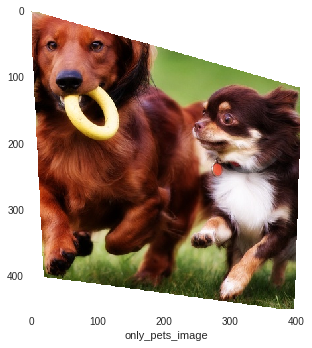

In [118]:
plt.figure()
plt.grid(False)
plt.imshow(only_pets_image)
plt.xlabel("only_pets_image")

In [0]:
def template_matching(image_data,template_matching_threshold,template_image):
	found_x = []
	found_y = []
	gray_image_data = cv2.cvtColor(image_data, cv2.COLOR_BGR2GRAY)
	font = cv2.FONT_HERSHEY_SIMPLEX
	
	w, h = template_image.shape[::-1]
	res = cv2.matchTemplate(gray_image_data,template_image,cv2.TM_CCOEFF_NORMED)
	loc = np.where( res >= template_matching_threshold)
	for pt in zip(*loc[::-1]):
		cv2.rectangle(image_data, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2) 
		cv2.putText(image_data,'Found',(pt[0],pt[1]), font, 2,(0,255,255),1,cv2.LINE_AA)
		found_x.append(pt[0])
		found_y.append(pt[1])
	found_x_cord = min(found_x)
	found_y_cord = min(found_y)
	template_matched_image = image_data	
	loop_detected_path = result_save_folder_path + "loop_detected_image.jpg"
	cv2.imwrite(loop_detected_path,template_matched_image)
	return template_matched_image,found_x_cord,found_y_cord

In [120]:
template_matching_threshold = 0.8
for files_present in files_in_content:
  if files_present.startswith("template"):
    image_file_full_path = "/content/" + files_present
    template_color_image_BGR = cv2.imread(image_file_full_path)
    template_gray_image = cv2.imread(image_file_full_path,0)
    template_image_height,template_image_width,template_image_channels = template_color_image_BGR.shape
    template_color_image_RGB = cv2.cvtColor(template_color_image_BGR,cv2.COLOR_BGR2RGB)
    print ('The image file present is {jpg_uploaded_file}'.format(jpg_uploaded_file = image_file_full_path))
    print ('The image dimension are, Height = {image_height},width = {image_width},Number of channels = {image_channels}'.format(image_height = template_image_height,image_width = template_image_width,image_channels = template_image_channels))

The image file present is /content/template.jpg
The image dimension are, Height = 90,width = 96,Number of channels = 3


Text(0.5,0,'template')

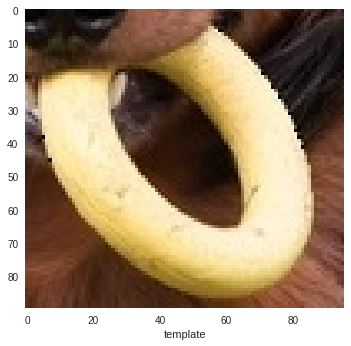

In [121]:
plt.figure()
plt.grid(False)
plt.imshow(template_color_image_RGB)
plt.xlabel("template")

In [0]:
def template_matching(only_pets_image,template_matching_threshold,template_gray_image):
	found_x = []
	found_y = []
	gray_image_data = cv2.cvtColor(only_pets_image, cv2.COLOR_BGR2GRAY)
	font = cv2.FONT_HERSHEY_SIMPLEX
		
	w, h = template_gray_image.shape[::-1]
	res = cv2.matchTemplate(gray_image_data,template_gray_image,cv2.TM_CCOEFF_NORMED)
	loc = np.where( res >= template_matching_threshold)
	for pt in zip(*loc[::-1]):
		cv2.rectangle(only_pets_image, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2) 
		cv2.putText(only_pets_image,'Found',(pt[0],pt[1]), font, 2,(0,255,255),1,cv2.LINE_AA)
		found_x.append(pt[0])
		found_y.append(pt[1])
	found_x_cord = min(found_x)
	found_y_cord = min(found_y)
	template_matched_image = only_pets_image	

	return template_matched_image,found_x_cord,found_y_cord



In [123]:
template_matching_threshold = 0.8
template_matched_image,found_x_cord,found_y_cord = template_matching(only_pets_image,template_matching_threshold,template_gray_image)
height,width,channel = template_matched_image.shape
if (found_x_cord > width/2 ):
  print ("PLUTO is the winner")
  print ("SHIMMY is runners-up")
else:
  print ("SHIMMY is the winner")
  print ("PLUTO is runners-up")

SHIMMY is the winner
PLUTO is runners-up


Text(0.5,0,'template_matched_image')

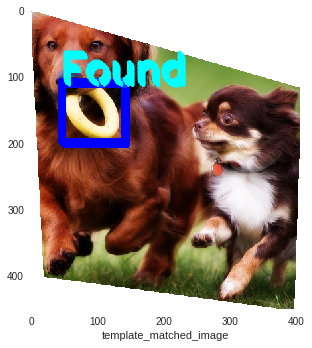

In [124]:
plt.figure()
plt.grid(False)
plt.imshow(template_matched_image)
plt.xlabel("template_matched_image")